### Import modules and verify they work? 

In [1]:
# general python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np
import os
from pathlib import Path
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy

In [2]:
# general eWC
import ewatercycle
import ewatercycle.models

Download plugin model

In [3]:
# pip install ewatercycle-HBV==1.0.0

#### set up paths

In [4]:
path = Path.cwd()
forcing_path = path / "Forcing"
forcing_path

PosixPath('/home/davidhaasnoot/eWaterCycle-WSL-WIP/Forcing')

#### add parameter info

In [5]:
## Array of initial storage terms - we keep these constant for now 
##              Si,  Su, Sf, Ss
s_0 = np.array([0,  100,  0,  5])

## Array of parameters min/max bounds as a reference
##                      Imax,  Ce,  Sumax, beta,  Pmax,  T_lag,   Kf,   Ks
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
p_names = ["$I_{max}$",  "$C_e$",  "$Su_{max}$", "β",  "$P_{max}$",  "$T_{lag}$",   "$K_f$",   "$K_s$"]
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]
param_names = ["Imax","Ce",  "Sumax", "Beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]
stor_names = ["Si", "Su", "Sf", "Ss"]

# set initial as mean of max,min
par_0 = (p_min_initial + p_max_initial)/2

In [6]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"

In [7]:
from ewatercycle_HBV.forcing import HBVForcing

In [8]:
test_forcing = HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          forcing_file = "test_forcing.txt",
                          )

In [9]:
ds = test_forcing.to_xarray()

# run containerised model

In [10]:
from ewatercycle_HBV.model import HBV

In [11]:
from ewatercycle.container import ContainerImage
model = HBV(forcing=test_forcing)

In [12]:
config_file, _ = model.setup(
            parameters=','.join([str(p) for p in par_0]),
            initial_storage=','.join([str(s) for s in s_0]),
           )

In [13]:
model.initialize(config_file)

In [14]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    Q_m.append(model.get_value("Q_m"))
    time.append(pd.Timestamp(model.time_as_datetime.date()))

In [15]:
df = pd.DataFrame(data=Q_m,columns=["Modeled discharge"],index=time)

In [16]:
Q_m_in_ref = np.loadtxt("Q_m_out_ref.txt")

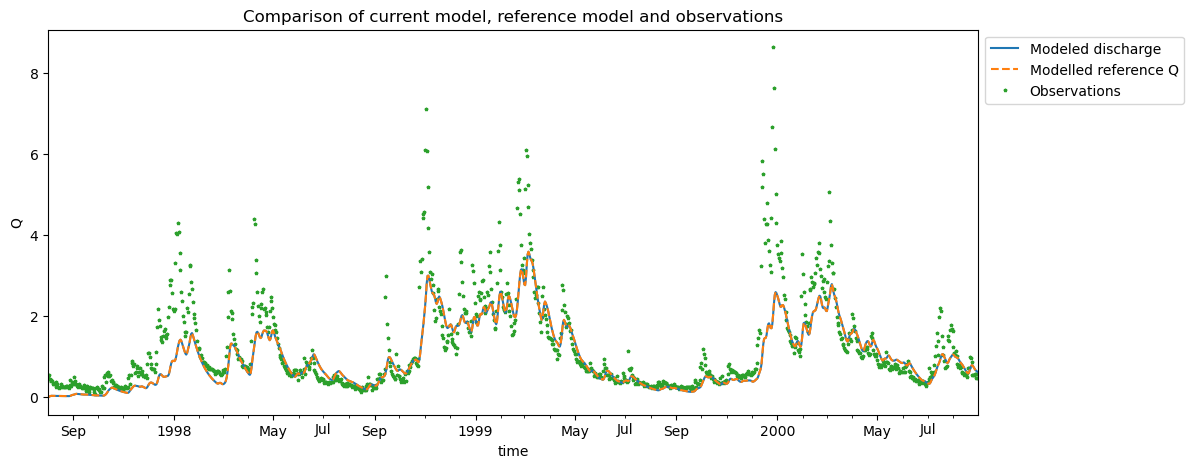

In [17]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
df.plot(ax=ax,label="Modeled discharge HBV-bmi")
ax.plot(df.index, Q_m_in_ref[:-1],ls="--",label="Modelled reference Q");
ds["Q"].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=-1,label="Observations")
ax.legend(bbox_to_anchor=(1,1))
ax.set_title("Comparison of current model, reference model and observations");

# Run for an ensemble

In [18]:
n_particles = 10

In [19]:
# for initial run sample a set of parameters - start with simpel linear random:  min+[0,1] * (max-min) -> easily changes after
array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)

In [20]:
ensemble = []
for i in range(n_particles):
    ensemble.append(HBV(forcing=test_forcing))

In [23]:
for index, ensembleMember in enumerate(ensemble):
    config_file, _ = ensembleMember.setup(
                                          parameters=','.join([str(p) for p in p_intial[index]]), 
                                          initial_storage=','.join([str(s) for s in s_0])
                                         )
    ensembleMember.initialize(config_file)

In [24]:
## TODO: fix file system makeing 100000 models? 

In [25]:
ref_model = ensemble[0]
ref_model.time_units

'seconds since 1970-01-01 00:00:00.0 +0000'

In [26]:
# TODO: fix timestep in 1.1

In [27]:
ref_model.time_step # should be 86400 = 24 * 3600 = 1 d

86400.0

In [29]:
ref_model = ensemble[0]
n_timesteps = int((ref_model.end_time - ref_model.start_time) / ref_model.time_step) # ref_model.timestep 

In [30]:
n_storage_terms = len(s_0)

In [31]:
Q_m_arr = np.zeros((n_particles,n_timesteps))
storage_terms_arr = np.zeros((n_particles, n_timesteps, n_storage_terms))

In [32]:
time = []
t_index = 0 
while ref_model.time < ref_model.end_time:
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))
    for index, ensembleMember in enumerate(ensemble):
        ensembleMember.update()
        Q_m_arr[index, t_index] = ensembleMember.get_value("Q_m")
        storage_terms = np.array([ensembleMember.get_value("Si"),ensembleMember.get_value("Su"),ensembleMember.get_value("Sf"),ensembleMember.get_value("Ss")]).flatten()
        storage_terms_arr[index, t_index] = storage_terms
    t_index+=1 

/tmp/ipykernel_13899/1380636522.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


In [33]:
# time

In [34]:
df_ensemble = pd.DataFrame(data=Q_m_arr.T,index=time,columns=[f'particle {n}' for n in range(n_particles)])

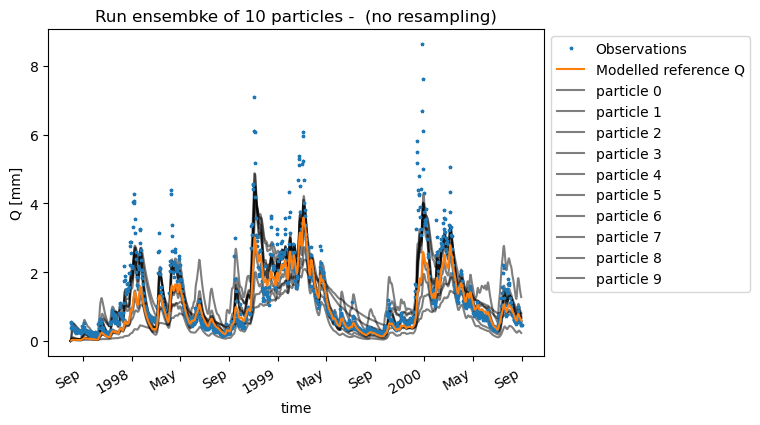

In [35]:
fig, ax = plt.subplots(1,1)
ds["Q"].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations")
ax.plot(df.index, Q_m_in_ref[1:],label="Modelled reference Q");
df_ensemble.plot(ax=ax,color="k",alpha=0.5,zorder=-1)
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensembke of {n_particles} particles -  (no resampling)");

# now start to retrieve state

In [36]:
import random
rng = np.random.default_rng() # Initiate a Random Number Generator

In [37]:
def setup_ensemble(n_particles):
    # for initial run sample a set of parameters - start with simpel linear random:  min+[0,1] * (max-min) -> easily changes after
    array_random_num = np.array([[np.random.random() for i in range(len(p_max_initial))] for i in range(n_particles)])
    p_intial = p_min_initial + array_random_num * (p_max_initial-p_min_initial)
    
    ensemble = []
    for i in range(n_particles):
        ensemble.append(HBV(forcing=test_forcing))
        
    for index, ensembleMember in enumerate(ensemble):
        config_file, _ = ensembleMember.setup(
                                              parameters=','.join([str(p) for p in p_intial[index]]), 
                                              initial_storage=','.join([str(s) for s in s_0])
                                             )
        ensembleMember.initialize(config_file)
        
    return ensemble 

def calc_NSE(Qo, Qm):
    """Calculates Nash-Sutcliffe Efficiency given set of observations (Qo) and model run result (Qm)"""
    QoAv  = np.mean(Qo)
    ErrUp = np.sum((Qm - Qo)**2)
    ErrDo = np.sum((Qo - QoAv)**2)
    return 1 - (ErrUp / ErrDo)


def generate_weights(Q_m_at_ts, obs):
    "Takes the enseble and observations and returns the posterior"
    prior = Q_m_at_ts # take last observation
    innov2 = (obs - prior)
    like_sigma = 0.05  # In [m]; so 5 mm
    unnormalised_log_weights = scipy.stats.norm.logpdf(innov2, loc=0, scale=like_sigma)
    normalised_weights = np.exp(unnormalised_log_weights - scipy.special.logsumexp(unnormalised_log_weights))
    return normalised_weights

def add_noise(like_sigma):
    return rng.normal(loc=0, scale=like_sigma)   # log normal so can't go to 0 ? 

In [38]:
n_particles = 10

In [40]:
# create list of ensemble members
ensemble = setup_ensemble(n_particles)
ref_model = ensemble[0]

In [41]:
# set up arrays
n_storage_terms = len(stor_names)
n_param_terms = len(param_names)
Q_m_arr = np.zeros((n_particles, n_timesteps))
storage_terms_arr = np.zeros((n_particles, n_timesteps, n_storage_terms))
parameter_terms_arr = np.zeros((n_particles, n_timesteps, n_param_terms))

In [42]:
print(param_names)
print(stor_names)

['Imax', 'Ce', 'Sumax', 'Beta', 'Pmax', 'Tlag', 'Kf', 'Ks']
['Si', 'Su', 'Sf', 'Ss']


In [43]:
# ref_model.start_time + 60 * 86400

In [54]:
time = []
t_index = 0 
while ref_model.time < ref_model.end_time:
    time.append(pd.Timestamp(ref_model.time_as_datetime.date()))

    # run model forward
    for m_index, ensembleMember in enumerate(ensemble):
        ensembleMember.update()
        # get
        Q_m_arr[m_index, t_index] = np.array([ensembleMember.get_value("Q_m")])
        storage_terms_arr[m_index, t_index] = np.array([ensembleMember.get_value(storage) for storage in stor_names]).flatten()
        parameter_terms_arr[m_index, t_index] = np.array([ensembleMember.get_value(parameter) for parameter in param_names]).flatten()
    
    Q_obs = ds.sel(time=np.asarray(np.array([ref_model.time]), dtype='datetime64[s]'))["Q"].values # get observed value from xarray
    likelihood = generate_weights(Q_m_arr[:,t_index], Q_obs) 
    resample_indices = random.choices(population=np.arange(n_particles),weights=likelihood, k=n_particles)
    
    new_parameters = parameter_terms_arr[:, t_index].copy()[resample_indices]
    new_storage    = storage_terms_arr[:, t_index].copy()[resample_indices]
    # new_lag        = lag_terms_prior[resample_indices] # dont have a way to set new lag function as of yet

    # add noise
    sigma = 0.005
    new_parameters = np.array([np.array([max(perturbed + add_noise(sigma),1e-6) for perturbed in par]) 
                               for par in new_parameters.T]).T
    new_storage    = np.array([np.array([max(perturbed + add_noise(sigma),1e-6) for perturbed in stor]) 
                               for stor in new_storage.T]).T
    # new_lag        = np.array([np.array([max(perturbed + add_noise(sigma),1e-6) for perturbed in lag]) 
    #                            for lag in new_lag.T]).T
    
    
    # update the parameters & states
    for index, ensembleMember in enumerate(ensemble):
        # TODO: adjust so that tLag cant go to 0
        print(new_parameters[index])
        print(np.array([new_parameters[index,0]]))
        [ensembleMember.set_value(parameter, np.array([new_parameters[index,p_index]])) for p_index, parameter in enumerate(param_names)]
        [ensembleMember.set_value(storage, np.array([new_storage[index,s_index]])) for s_index, storage in enumerate(stor_names)]
            # ensembleMember.set_value("memory_vector_lag", new_lag[index])

    # advance the index
    t_index+=1 

/tmp/ipykernel_13899/3537902996.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


[4.75593459e-01 8.43978238e-01 1.86158161e+02 9.08811225e-01
 3.37478742e-02 2.00135416e+00 1.04570339e-02 5.28959974e-03]
[0.47559346]
[4.67031543e-01 8.45072689e-01 1.86168345e+02 8.92217631e-01
 3.24458347e-02 1.99466300e+00 1.57534242e-02 1.00000000e-06]
[0.46703154]
[2.97115118e-02 9.61455573e-01 2.17730916e+02 1.57720933e+00
 9.93564219e-02 2.00690191e+00 2.08798293e-02 3.25901148e-03]
[0.02971151]
[4.72026021e-01 8.45026210e-01 1.86151613e+02 9.01665621e-01
 3.42180791e-02 1.99392494e+00 2.15756783e-02 5.85034195e-03]
[0.47202602]
[4.65029283e-01 8.43770515e-01 1.86162596e+02 9.08874673e-01
 2.60575907e-02 2.00288269e+00 1.80894431e-02 1.76015054e-03]
[0.46502928]
[4.62595804e-01 8.40498385e-01 1.86162427e+02 8.92658485e-01
 3.59252744e-02 1.99981637e+00 2.53407423e-02 1.18251439e-03]
[0.4625958]
[4.65211056e-01 8.44753411e-01 1.86159905e+02 8.98165246e-01
 2.71238167e-02 2.00559823e+00 2.21732660e-02 1.00000000e-06]
[0.46521106]
[4.67860229e-01 8.33282323e-01 1.86150619e+02 8.9

RemoteException: ZeroDivisionError('float division by zero')

In [49]:
new_parameters[index,0]

0.46350841304202256

In [ ]:
df_ensemble = pd.DataFrame(data=Q_m_arr[:,:len(time)].T,index=time,columns=[f'particle {n}' for n in range(n_particles)])

In [ ]:
# df_ensemble.plot()
fig, ax = plt.subplots(1,1)
ds["Q"].plot(ax=ax,lw=0,marker="*",ms=2.5,zorder=0,label="Observations")
ax.plot(df.index, Q_m_in_ref[1:],label="Modelled reference Q");
df_ensemble.plot(ax=ax,color="k",alpha=0.5,zorder=-1)
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel("Q [mm]")
ax.set_title(f"Run ensembke of {n_particles} particles -  (no resampling)");

In [ ]:
plt.plot(parameter_terms_arr[:,-1,0].T);
plt.plot(new_parameters[:,0])

In [ ]:
len(parameter_terms_arr[:,0] )

In [ ]:
parameter_terms_arr[:,0][resample_indices]